In [ ]:
import numpy as np
import pandas as pd 

In [4]:
eye_train = pd.read_csv('D:/blindness-detection/train.csv')
df_train = eye_train.copy()
df_train.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [5]:
eye_test = pd.read_csv('D:/blindness-detection/test.csv')
df_test = eye_test.copy()
df_test.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


In [6]:
df_train.shape, df_test.shape

((3662, 2), (1928, 1))

In [7]:
df_train.isna().sum()

id_code      0
diagnosis    0
dtype: int64

In [8]:
frequencies = df_train.diagnosis.value_counts()
frequencies

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

In [9]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from tqdm import tqdm

Using TensorFlow backend.


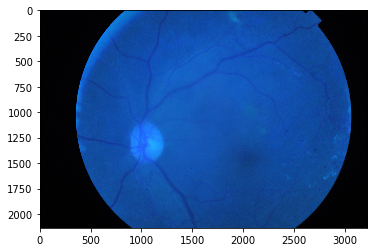

In [10]:
image = cv2.imread('D:/blindness-detection/train_images/cd54d022e37d.png')
plt.imshow(image)

In [13]:
def preprocess_image(image_path, desired_size=224):
    im = Image.open(image_path)
    im = im.resize((desired_size, )*2, resample=Image.LANCZOS)
    
    return im

In [14]:
N = df_train.shape[0]
x_train = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(df_train['id_code'])):
    x_train[i, :, :, :] = preprocess_image(
        'D:/blindness-detection/train_images/{image_id}.png'
    )

100%|██████████| 3662/3662 [08:47<00:00,  6.95it/s]


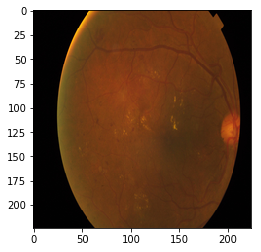

In [15]:
plt.imshow(x_train[0])

In [16]:
N = df_test.shape[0]
x_test = np.empty((N, 224, 224, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm(df_test['id_code'])):
    x_test[i, :, :, :] = preprocess_image(
        'D:/blindness-detection/test_images/{image_id}.png'
    )

100%|██████████| 1928/1928 [01:36<00:00, 20.05it/s]


In [17]:
y_train = pd.get_dummies(df_train['diagnosis']).values
x_train.shape, y_train.shape

((3662, 224, 224, 3), (3662, 5))

In [18]:
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, 
    test_size=0.15, 
    random_state=1111
)

In [19]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((3112, 224, 224, 3), (3112, 5), (550, 224, 224, 3), (550, 5))

In [20]:
BATCH_SIZE = 32

def create_datagen():
    return ImageDataGenerator(
        zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Using original generator
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE, seed=1111)

In [21]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')

        return

In [22]:
densenet = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

29089792/29084464 [==============================] - 0s 0us/step


In [23]:
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.00005),
        metrics=['accuracy']
    )
    
    return model

In [25]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 7, 7, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________


In [26]:
kappa_metrics = Metrics()

history = model.fit_generator(
    data_generator,
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=15,
    validation_data=(x_val, y_val),
    callbacks=[kappa_metrics]
)

Epoch 1/15
98/97 [==============================] - 125s 1s/step - loss: 0.4464 - accuracy: 0.7928 - val_loss: 0.4297 - val_accuracy: 0.7564
val_kappa: 0.0000
Validation Kappa has improved. Saving model.
Epoch 2/15
98/97 [==============================] - 52s 528ms/step - loss: 0.2630 - accuracy: 0.8925 - val_loss: 0.2341 - val_accuracy: 0.9018
val_kappa: 0.0000
Validation Kappa has improved. Saving model.
Epoch 3/15
98/97 [==============================] - 52s 529ms/step - loss: 0.2220 - accuracy: 0.9084 - val_loss: 0.2105 - val_accuracy: 0.9047
val_kappa: 0.0000
Validation Kappa has improved. Saving model.
Epoch 4/15
98/97 [==============================] - 52s 531ms/step - loss: 0.2020 - accuracy: 0.9161 - val_loss: 0.1994 - val_accuracy: 0.9113
val_kappa: 0.0000
Validation Kappa has improved. Saving model.
Epoch 5/15
98/97 [==============================] - 51s 525ms/step - loss: 0.1832 - accuracy: 0.9258 - val_loss: 0.1661 - val_accuracy: 0.9273
val_kappa: 0.0000
Validation Kappa 